<a href="https://colab.research.google.com/github/mtavakoliangit/uofc_mythesis/blob/main/LessNN_Langmuir_allC1_Functionalkeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense
from keras.layers import Dense, Activation, Dropout
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
from keras.callbacks import History
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf

In [ ]:
import pickle
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output
from sklearn.linear_model import LinearRegression

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd 
data_df=pd.read_csv('gdrive/My Drive/CO2_Database/groupedC1_minusConstP.csv')

In [ ]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1661 entries, 0 to 1660
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Gas                          1661 non-null   object 
 1   Rock                         1661 non-null   object 
 2   TOC (%)                      1661 non-null   float64
 3   Moisture (%)                 1661 non-null   float64
 4   Temp (C)                     1661 non-null   float64
 5   Pres. (MPa)                  1661 non-null   float64
 6   C1 Excess Sorption (cm3/gr)  1661 non-null   float64
dtypes: float64(5), object(2)
memory usage: 91.0+ KB


In [ ]:
data_df.describe()

,TOC (%),Moisture (%),Temp (C),Pres. (MPa),C1 Excess Sorption (cm3/gr)
count,1661.000000,1661.000000,1661.000000,1661.000000,1661.000000
mean,15.649607,1.096797,56.230825,9.665183,1.493944
std,25.923400,1.895442,16.056862,7.080627,1.378896
min,0.090000,0.000000,30.000000,0.164000,0.001600
25%,2.364292,0.000000,38.000000,3.390000,0.502000
50%,5.150000,0.000000,61.000000,8.418500,1.147800
75%,7.700000,1.720000,65.000000,15.119500,2.050500
max,88.500000,7.340000,150.000000,27.861700,7.036200


In [ ]:
# Function to insert row in the dataframe
def Insert_row(row_number, df, row_value):
	# Starting value of upper half
	start_upper = 0

	# End value of upper half
	end_upper = row_number

	# Start value of lower half
	start_lower = row_number

	# End value of lower half
	end_lower = df.shape[0]

	# Create a list of upper_half index
	upper_half = [*range(start_upper, end_upper, 1)]

	# Create a list of lower_half index
	lower_half = [*range(start_lower, end_lower, 1)]

	# Increment the value of lower half by 1
	lower_half = [x.__add__(1) for x in lower_half]

	# Combine the two lists
	index_ = upper_half + lower_half

	# Update the index of the dataframe
	df.index = index_

	# Insert a row at the end
	df.loc[row_number] = row_value

	# Sort the index labels
	df = df.sort_index()

	# return the dataframe
	return df

In [ ]:
# Define the Langmuir equation
def Langmuir(P, VL, pL):
    V_ads = VL * P / (P + pL)
    return V_ads

#### Adding P=0, sorption=0 to the datasets, counting the number of datasets (experiments):

In [ ]:
i = 0
row_value = [data_df['Gas'][i], data_df['Rock'][i], data_df['TOC (%)'][i], data_df['Moisture (%)'][i], data_df['Temp (C)'][i], 0, 0]
data_df = Insert_row(i, data_df, row_value)

In [ ]:
P = []
sorp = []
polyfit_df = pd.DataFrame(columns=['Gas', 'Rock', 'TOC (%)', 'Moisture (%)', 'Temp (C)', 'VL', 'pL'])
# df_backup is a shadow of polyfit_df to be used for de-normalisation 
df_backup = pd.DataFrame(columns=['Gas', 'Rock', 'TOC (%)', 'Moisture (%)', 'Temp (C)', 'VL', 'pL'])

In [ ]:
while i < data_df.shape[0] - 1:
    i += 1
    if data_df['Pres. (MPa)'][i] > data_df['Pres. (MPa)'][i-1]:
        P.append(data_df['Pres. (MPa)'][i-1])
        sorp.append(data_df['C1 Excess Sorption (cm3/gr)'][i-1])
    else:
        P.append(data_df['Pres. (MPa)'][i-1])
        sorp.append(data_df['C1 Excess Sorption (cm3/gr)'][i-1])
        row_value = [data_df['Gas'][i], data_df['Rock'][i], data_df['TOC (%)'][i], data_df['Moisture (%)'][i], data_df['Temp (C)'][i], 0, 0]
        data_df = Insert_row(i, data_df, row_value)
        #calculating Langmuir equation parameters
        parameters, covariance = curve_fit(Langmuir, P, sorp)
        VL = parameters[0]
        pL = parameters[1]
        polyfit_df = polyfit_df.append({'Gas': data_df['Gas'][i], 'Rock': data_df['Rock'][i], 'TOC (%)': data_df['TOC (%)'][i], 'Moisture (%)': data_df['Moisture (%)'][i],
                                        'Temp (C)': data_df['Temp (C)'][i], 'VL': VL, 'pL': pL},ignore_index=True)
        df_backup = df_backup.append({'Gas': data_df['Gas'][i], 'Rock': data_df['Rock'][i], 'TOC (%)': data_df['TOC (%)'][i], 'Moisture (%)': data_df['Moisture (%)'][i],
                                        'Temp (C)': data_df['Temp (C)'][i], 'VL': VL, 'pL': pL},ignore_index=True)
        P = []
        sorp = []

#last experimental data set:
P.append(data_df['Pres. (MPa)'][data_df.shape[0]-1])
sorp.append(data_df['C1 Excess Sorption (cm3/gr)'][data_df.shape[0]-1])
parameters, covariance = curve_fit(Langmuir, P, sorp)
VL = parameters[0]
pL = parameters[1]
polyfit_df = polyfit_df.append({'Gas': data_df['Gas'][i], 'Rock': data_df['Rock'][i], 'TOC (%)': data_df['TOC (%)'][i], 'Moisture (%)': data_df['Moisture (%)'][i],
                                'Temp (C)': data_df['Temp (C)'][i], 'VL': VL, 'pL': pL},ignore_index=True)
df_backup = df_backup.append({'Gas': data_df['Gas'][i], 'Rock': data_df['Rock'][i], 'TOC (%)': data_df['TOC (%)'][i], 'Moisture (%)': data_df['Moisture (%)'][i],
                              'Temp (C)': data_df['Temp (C)'][i], 'VL': VL, 'pL': pL},ignore_index=True)

In [ ]:
num_exp = polyfit_df.shape[0] #number of experimental datasets

In [ ]:
polyfit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Gas           122 non-null    object 
 1   Rock          122 non-null    object 
 2   TOC (%)       122 non-null    float64
 3   Moisture (%)  122 non-null    float64
 4   Temp (C)      122 non-null    float64
 5   VL            122 non-null    float64
 6   pL            122 non-null    float64
dtypes: float64(5), object(2)
memory usage: 6.8+ KB


In [ ]:
polyfit_df.head()

,Gas,Rock,TOC (%),Moisture (%),Temp (C),VL,pL
0,CH4,Shale/Clay,0.44,0.66,50.0,0.953745,8.952624
1,CH4,Shale/Clay,0.09,1.51,38.0,0.296337,7.840025
2,CH4,Shale/Clay,3.25,1.47,38.0,0.896418,15.344013
3,CH4,Shale/Clay,0.38,1.87,38.0,1.174007,16.522328
4,CH4,Shale/Clay,0.75,0.59,38.0,0.998552,29.268973


## Having looked at the calculated VL and pL, I realised that 3 of them are huge numbers. The rest are below 10. So, I am going to delete those rows.

In [ ]:
max(polyfit_df['VL'])

42053877.18008987

In [ ]:
polyfit_df_filtered = polyfit_df[polyfit_df['VL'] <= 10]
df = polyfit_df_filtered

In [ ]:
df_backup = df_backup[df_backup['VL'] <= 10]

In [ ]:
max(df['VL'])

8.889353108394078

In [ ]:
df.to_csv(r'gdrive/My Drive/CO2_Database/groupedC1_Langmuir.csv')

In [ ]:
cols = ['TOC (%)', 'Moisture (%)', 'Temp (C)', 'VL', 'pL']
for col in cols:
  #scale = StandardScaler().fit(df[[col]])
  #df[[col]] = scale.transform(df[[col]])
  norm = MinMaxScaler().fit(df[[col]])
  df[[col]] = norm.transform(df[[col]])
  df_backup[[col]] = norm.transform(df_backup[[col]])

In [ ]:
df.describe()

,TOC (%),Moisture (%),Temp (C),VL,pL
count,119.000000,119.000000,119.000000,119.000000,119.000000
mean,0.176383,0.188022,0.216106,0.276137,0.189086
std,0.298747,0.261458,0.141679,0.236291,0.148673
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025724,0.000000,0.066667,0.085576,0.104960
50%,0.055989,0.000000,0.258333,0.218190,0.144083
75%,0.086076,0.408719,0.291667,0.372573,0.236718
max,1.000000,1.000000,1.000000,1.000000,1.000000


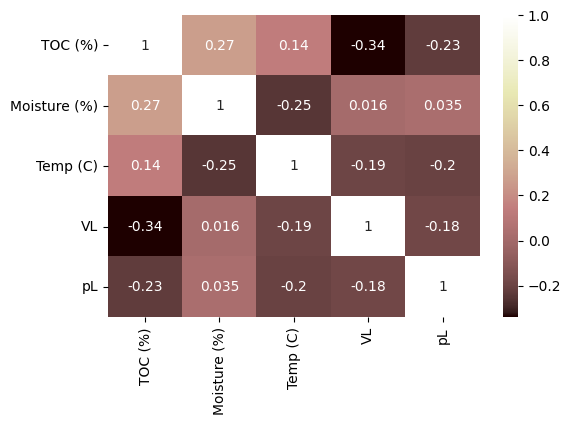

In [ ]:
sns.heatmap(df.corr(), cmap="pink", annot=True)

In [ ]:
df['Rock'].unique()

array(['Shale/Clay', 'Coal'], dtype=object)

### One-hot encoding for the Gas and Rock columns:

In [ ]:
gas_dic = {'CH4': 0, 'CO2': 1}
df.Gas = [gas_dic[item] for item in df.Gas]
df_backup.Gas = [gas_dic[item] for item in df_backup.Gas]

In [ ]:
rock_dic = {'Shale/Clay': 0, 'Coal': 1}
df.Rock = [rock_dic[item] for item in df.Rock]
df_backup.Rock = [rock_dic[item] for item in df_backup.Rock]

In [ ]:
x = df.drop(['VL', 'pL'],axis=1)
y = df[['VL', 'pL']]
x_backup = df_backup.drop(['VL', 'pL'],axis=1)
y_backup = df_backup[['VL', 'pL']]

### Because we have only C1 here, I am going to drop the Gas column:

In [ ]:
x = x.drop(['Gas'], axis=1)
x_backup = x_backup.drop(['Gas'], axis=1)

In [ ]:
x.head()

,Rock,TOC (%),Moisture (%),Temp (C)
0,0,0.003959,0.089918,0.166667
1,0,0.000000,0.205722,0.066667
2,0,0.035743,0.200272,0.066667
3,0,0.003280,0.254768,0.066667
4,0,0.007465,0.080381,0.066667


In [ ]:
x['Rock'].unique()

array([0, 1])

In [ ]:
x_backup - x

,Rock,TOC (%),Moisture (%),Temp (C)
0,0,0.0,0.0,0.0
1,0,0.0,0.0,0.0
2,0,0.0,0.0,0.0
3,0,0.0,0.0,0.0
4,0,0.0,0.0,0.0
...,...,...,...,...
117,0,0.0,0.0,0.0
118,0,0.0,0.0,0.0
119,0,0.0,0.0,0.0
120,0,0.0,0.0,0.0


In [ ]:
y_backup - y

,VL,pL
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
117,0.0,0.0
118,0.0,0.0
119,0.0,0.0
120,0.0,0.0


In [ ]:
y_backup

,VL,pL
0,0.086244,0.320739
1,0.010546,0.283540
2,0.079644,0.534430
3,0.111607,0.573826
4,0.091404,1.000000
...,...,...
117,0.650420,0.068593
118,0.583528,0.073362
119,0.430523,0.074457
120,0.336135,0.084450


In [ ]:
RAND_STAT = 50

In [ ]:
#Create train and test dataset with an 80:20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=RAND_STAT)
#Further divide training dataset into train and validation dataset with an 90:10 split
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=RAND_STAT)
#Check the sizes of all newly created datasets
print("Shape of x_train:",x_train.shape)
print("Shape of x_val:",x_val.shape)
print("Shape of x_test:",x_test.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of y_val:",y_val.shape)
print("Shape of y_test:",y_test.shape)

Shape of x_train: (101, 4)
Shape of x_val: (12, 4)
Shape of x_test: (6, 4)
Shape of y_train: (101, 2)
Shape of y_val: (12, 2)
Shape of y_test: (6, 2)


In [ ]:
x_train=np.asarray(x_train).astype(np.float32)
y_train=np.asarray(y_train).astype(np.float32)
x_val=np.asarray(x_val).astype(np.float32)
y_val=np.asarray(y_val).astype(np.float32)

In [ ]:
history = History()
#Defining Functional model
input_layer = Input(shape=(4,))
Layer_1 = Dense(50,activation="tanh")(input_layer)
Layer_2 = Dense(10,activation="relu")(Layer_1)
#Layer_3 = Dense(100,activation="relu")(Layer_2)
#Layer_4 = Dense(40,activation="relu")(Layer_3)
#Layer_5 = Dense(10,activation="tanh")(Layer_4)
output_layer = Dense(2,activation="tanh")(Layer_2)
model = Model(inputs=input_layer, outputs=output_layer)
#Configure the model
keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)
model.compile(optimizer='SGD',loss="mean_squared_logarithmic_error",metrics=["mean_absolute_error"])
#Train the model
model.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100,batch_size=8,callbacks=[history])

Epoch 1/100
13/13 [==============================] - 1s 30ms/step - loss: 0.0527 - mean_absolute_error: 0.2432 - val_loss: 0.0363 - val_mean_absolute_error: 0.1938
Epoch 2/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0458 - mean_absolute_error: 0.2168 - val_loss: 0.0310 - val_mean_absolute_error: 0.1692
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0400 - mean_absolute_error: 0.1979 - val_loss: 0.0274 - val_mean_absolute_error: 0.1504
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0356 - mean_absolute_error: 0.1806 - val_loss: 0.0248 - val_mean_absolute_error: 0.1398
Epoch 5/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0323 - mean_absolute_error: 0.1681 - val_loss: 0.0230 - val_mean_absolute_error: 0.1326
Epoch 6/100
13/13 [==============================] - 0s 10ms/step - loss: 0.0298 - mean_absolute_error: 0.1591 - val_loss: 0.0218 - val_mean_absolute_error: 0.1280
Epoch 7/100
13/13 [

In [ ]:
x_test=np.asarray(x_test).astype(np.float32)
y_test=np.asarray(y_test).astype(np.float32)
x_backup=np.asarray(x_backup).astype(np.float32)
y_backup=np.asarray(y_backup).astype(np.float32)

In [ ]:
result = model.evaluate(x_test,y_test)
for i in range(len(model.metrics_names)):
    print("Metric ",model.metrics_names[i],":",str(round(result[i],2)))

1/1 [==============================] - 0s 66ms/step - loss: 0.0125 - mean_absolute_error: 0.1123
Metric  loss : 0.01
Metric  mean_absolute_error : 0.11


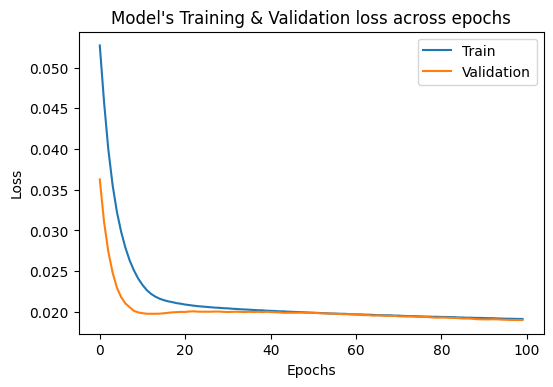

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model's Training & Validation loss across epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [ ]:
y_backup_pred = model.predict(x_backup)

In [ ]:
def linear_model_results(axes_num, y_actual, y_prediction, title):
    linear_model = LinearRegression().fit(y_actual.reshape(-1, 1), y_prediction.reshape(-1, 1))
    r_sq = linear_model.score(y_actual.reshape(-1, 1), y_prediction.reshape(-1, 1))
    print('coefficient of determination:', r_sq)
    print('coef_:', linear_model.coef_)
    print('intercept:', linear_model.intercept_)
    
    axes[axes_num].plot(y_actual,  linear_model.coef_[0][0] * y_actual + linear_model.intercept_[0],
                linestyle='--', color = 'darkblue')  
    axes[axes_num].scatter(y_actual, y_prediction,
                            linewidths=2, edgecolor='black', color = 'lightblue') 
    axes[axes_num].set_xlabel('Actual')
    axes[axes_num].set_ylabel(title)

coefficient of determination: 0.14324188905126678
coef_: [[0.04257036]]
intercept: [0.2800023]


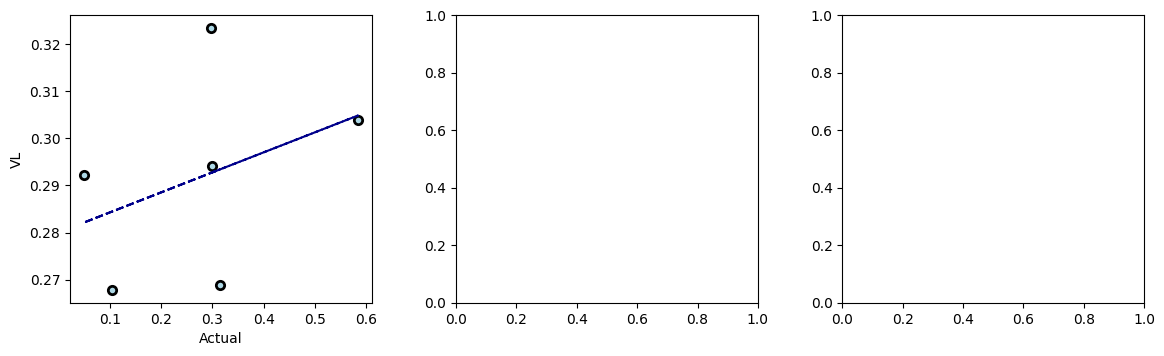

In [ ]:
#ACTUAL vs PREDICTED for ANN

fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.tight_layout(pad=3.0)

linear_model_results(0, y_test[:,0], y_test_pred[:,0], 'VL')

coefficient of determination: 0.2721477009250842
coef_: [[0.04154528]]
intercept: [0.19183269]


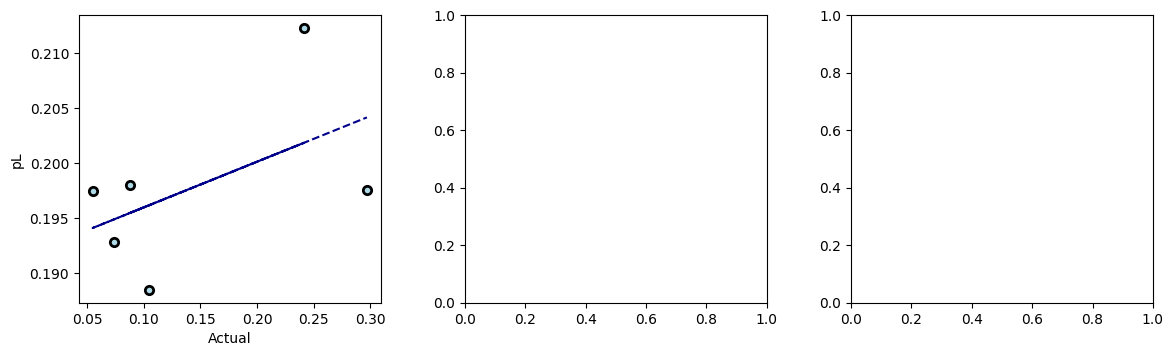

In [ ]:
#ACTUAL vs PREDICTED for ANN

fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.tight_layout(pad=3.0)

linear_model_results(0, y_test[:,1], y_test_pred[:,1], 'pL')

coefficient of determination: 0.12603706495345623
coef_: [[0.11398218]]
intercept: [0.22764544]


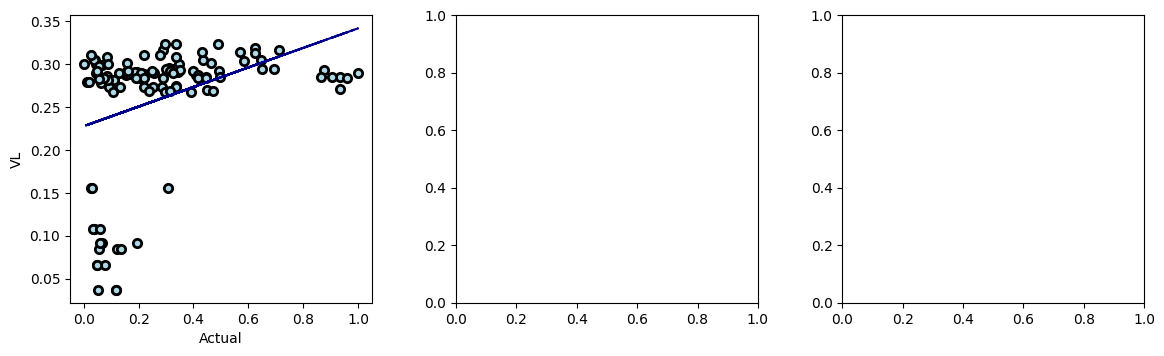

In [ ]:
#ACTUAL vs PREDICTED for ANN

fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.tight_layout(pad=3.0)

linear_model_results(0, y_backup[:,0], y_backup_pred[:,0], 'VL')

coefficient of determination: 0.007268622630447252
coef_: [[0.0209916]]
intercept: [0.18696094]


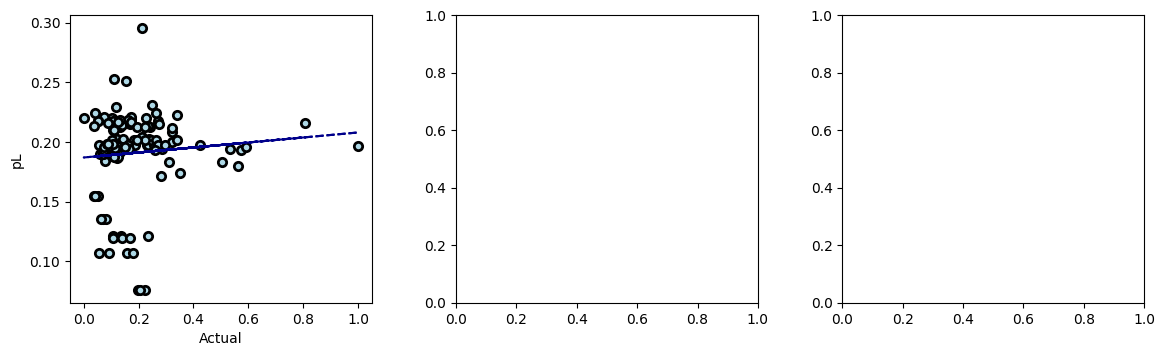

In [ ]:
#ACTUAL vs PREDICTED for ANN

fig, axes = plt.subplots(1, 3, figsize=(12,4))
fig.tight_layout(pad=3.0)

linear_model_results(0, y_backup[:,1], y_backup_pred[:,1], 'pL')

In [ ]:
y_backup_pred

array([[0.28601044, 0.19961609],
       [0.2787184 , 0.19425884],
       [0.2814601 , 0.19415107],
       [0.28118607, 0.19324893],
       [0.27365947, 0.19672422],
       [0.2783288 , 0.19598675],
       [0.3087957 , 0.20443346],
       [0.30028406, 0.23112985],
       [0.2994178 , 0.20839784],
       [0.30528176, 0.21793148],
       [0.3005592 , 0.224605  ],
       [0.30447838, 0.2117784 ],
       [0.29801413, 0.21475497],
       [0.31106204, 0.20094256],
       [0.28997242, 0.19861375],
       [0.27932957, 0.18680935],
       [0.30139616, 0.17103532],
       [0.2920621 , 0.182765  ],
       [0.29427093, 0.1739843 ],
       [0.29545498, 0.18008186],
       [0.2877228 , 0.18340099],
       [0.27341723, 0.19743554],
       [0.28741753, 0.19149946],
       [0.3003364 , 0.25111374],
       [0.28417885, 0.22286616],
       [0.28867394, 0.21919438],
       [0.27346718, 0.19747253],
       [0.29420552, 0.18850288],
       [0.27368852, 0.22917631],
       [0.28766048, 0.22075666],
       [0.

In [ ]:
pd.DataFrame(abs(y_test_pred - y_test)*100/y_test)

,0,1
0,1.829879,79.961914
1,47.922798,162.876801
2,154.477127,260.500671
3,490.757477,12.005931
4,8.758453,126.551445
5,14.661581,33.461304


In [ ]:
x_backup

array([[0.        , 0.00395883, 0.08991826, 0.16666667],
       [0.        , 0.        , 0.20572206, 0.06666667],
       [0.        , 0.03574256, 0.20027249, 0.06666667],
       [0.        , 0.00328017, 0.2547684 , 0.06666667],
       [0.        , 0.00746522, 0.08038147, 0.06666667],
       [0.        , 0.04965502, 0.10490463, 0.06666667],
       [0.        , 0.01153716, 0.16893733, 0.33333334],
       [0.        , 0.04456509, 0.03542234, 0.45833334],
       [0.        , 0.01854994, 0.07493188, 0.30833334],
       [0.        , 0.00407194, 0.08310626, 0.41666666],
       [0.        , 0.01436489, 0.02724796, 0.43333334],
       [0.        , 0.03110508, 0.1253406 , 0.35      ],
       [0.        , 0.01357313, 0.03542234, 0.35      ],
       [0.        , 0.02544961, 0.23433243, 0.30833334],
       [0.        , 0.00565547, 0.15258856, 0.175     ],
       [0.        , 0.11390115, 0.35831064, 0.        ],
       [0.        , 0.06741319, 1.        , 0.        ],
       [0.        , 0.08019455,

In [ ]:
y_backup

array([[0.08624443, 0.32073873],
       [0.01054634, 0.28353983],
       [0.07964352, 0.53442985],
       [0.11160679, 0.5738259 ],
       [0.09140386, 1.        ],
       [0.06310102, 0.5918629 ],
       [0.0849071 , 0.21309505],
       [0.04609964, 0.24820489],
       [0.06699357, 0.32237694],
       [0.04262696, 0.27059162],
       [0.        , 0.2636465 ],
       [0.03913086, 0.32219386],
       [0.05530733, 0.27302825],
       [0.02769818, 0.25813308],
       [0.04398864, 0.16188456],
       [0.01813615, 0.12276306],
       [0.46540567, 0.28242242],
       [0.49480537, 0.5023161 ],
       [0.32578608, 0.35156626],
       [0.3094399 , 0.5628873 ],
       [0.15499108, 0.31060454],
       [0.21945873, 0.22933432],
       [0.20931084, 0.13322607],
       [0.08693251, 0.15403415],
       [0.2042247 , 0.34060204],
       [0.18803488, 0.17322668],
       [0.25123903, 0.10728464],
       [0.29968947, 0.10474598],
       [0.13223961, 0.11595635],
       [0.40953127, 0.17247348],
       [0.

In [ ]:
y_backup_pred

array([[0.28601044, 0.19961609],
       [0.2787184 , 0.19425884],
       [0.2814601 , 0.19415107],
       [0.28118607, 0.19324893],
       [0.27365947, 0.19672422],
       [0.2783288 , 0.19598675],
       [0.3087957 , 0.20443346],
       [0.30028406, 0.23112985],
       [0.2994178 , 0.20839784],
       [0.30528176, 0.21793148],
       [0.3005592 , 0.224605  ],
       [0.30447838, 0.2117784 ],
       [0.29801413, 0.21475497],
       [0.31106204, 0.20094256],
       [0.28997242, 0.19861375],
       [0.27932957, 0.18680935],
       [0.30139616, 0.17103532],
       [0.2920621 , 0.182765  ],
       [0.29427093, 0.1739843 ],
       [0.29545498, 0.18008186],
       [0.2877228 , 0.18340099],
       [0.27341723, 0.19743554],
       [0.28741753, 0.19149946],
       [0.3003364 , 0.25111374],
       [0.28417885, 0.22286616],
       [0.28867394, 0.21919438],
       [0.27346718, 0.19747253],
       [0.29420552, 0.18850288],
       [0.27368852, 0.22917631],
       [0.28766048, 0.22075666],
       [0.

In [ ]:
from numpy import array
test = array([0.        , 0.        , 0.20572206, 0.06666667])
test = test.reshape((1, 4, 1))
model.predict(test)

array([[0.2787184 , 0.19425884]], dtype=float32)

In [ ]:
x_test = pd.DataFrame(x_test)
y_test = pd.DataFrame(y_test)
y_test_pred = pd.DataFrame(y_test_pred)

In [ ]:
x_test.head()

,0,1,2,3
0,0.0,0.074765,0.449591,0.066667
1,0.0,0.052822,0.408719,0.166667
2,0.0,0.019342,0.000000,0.041667
3,0.0,0.023910,0.000000,0.295000
4,0.0,0.052822,0.408719,0.333333


In [ ]:
y_test.head()

,0,1
0,0.299689,0.104746
1,0.583528,0.073362
2,0.105266,0.054780
3,0.049449,0.241227
4,0.297303,0.087402


In [ ]:
x_test = x_test.rename(columns={0: 'Rock', 1: 'TOC (%)', 2: 'Moisture (%)', 3: 'Temp (C)'})
y_test = y_test.rename(columns={0: 'VL', 1: 'pL'})
y_test_pred = y_test_pred.rename(columns={0: 'VL', 1: 'pL'})

In [ ]:
rock_dic = {0: 'Shale/Clay', 1: 'Coal'}
x_test.Rock = [rock_dic[item] for item in x_test.Rock]

In [ ]:
cols = ['TOC (%)', 'Moisture (%)', 'Temp (C)']
for col in cols:
  norm = MinMaxScaler().fit(df_backup[[col]])
  x_test[[col]] = norm.inverse_transform(x_test[[col]])

In [ ]:
cols = ['VL', 'pL']
for col in cols:
  norm = MinMaxScaler().fit(df_backup[[col]])
  y_test[[col]] = norm.inverse_transform(y_test[[col]])
  y_test_pred[[col]] = norm.inverse_transform(y_test_pred[[col]])

In [ ]:
x_test

,Rock,TOC (%),Moisture (%),Temp (C)
0,Shale/Clay,0.074765,0.449591,0.066667
1,Shale/Clay,0.052822,0.408719,0.166667
2,Shale/Clay,0.019342,0.000000,0.041667
3,Shale/Clay,0.023910,0.000000,0.295000
4,Shale/Clay,0.052822,0.408719,0.333333
5,Shale/Clay,0.025724,0.000000,0.045000


In [ ]:
y_test

,VL,pL
0,0.299689,0.104746
1,0.583528,0.073362
2,0.105266,0.054780
3,0.049449,0.241227
4,0.297303,0.087402
5,0.315017,0.296891


In [ ]:
y_test_pred

,VL,pL
0,0.294206,0.188503
1,0.303885,0.192851
2,0.267878,0.197482
3,0.292124,0.212266
4,0.323342,0.198010
5,0.268831,0.197547


### We are now going to test our model and predict using real experimental data:

In [ ]:
#for denormalisation purpose
norm_VL = MinMaxScaler().fit(df_backup[['VL']])
norm_pL = MinMaxScaler().fit(df_backup[['pL']])

In [ ]:
i = 0
P = []
sorp_exp = []
sorp_pred = []
num_exp = 1
cols = ['VL', 'pL']
Result = []

P.append(data_df['Pres. (MPa)'][i])
sorp_exp.append(data_df['C1 Excess Sorption (cm3/gr)'][i])

while i < data_df.shape[0] - 1:
    i += 1
    if data_df['Pres. (MPa)'][i] > data_df['Pres. (MPa)'][i-1]:
        #experimental data:
        P.append(data_df['Pres. (MPa)'][i-1])
        sorp_exp.append(data_df['C1 Excess Sorption (cm3/gr)'][i-1])
    else:
        #experimental data (cont'd):
        P.append(data_df['Pres. (MPa)'][i-1])
        sorp_exp.append(data_df['C1 Excess Sorption (cm3/gr)'][i-1])
        #model prediction:
        poly_coef = df.iloc[[num_exp-1]]
        feed = poly_coef[['Rock', 'TOC (%)', 'Moisture (%)', 'Temp (C)']]
        result = model.predict(feed)

        result[0][0] = norm_VL.inverse_transform(result[0][0].reshape(1, -1))
        result[0][1] = norm_pL.inverse_transform(result[0][1].reshape(1, -1))
        Result.append(result)
        
        for j in range(0, len(P)):
            sorp_pred.append(result[0][0]*P[j]**3 + result[0][1]*P[j]**2 + result[0][2]*P[j] + result[0][3])
            #print(sorp_exp[j], sorp_pred[j])
            #print(100*(sorp_pred[j] - sorp_exp[j])/sorp_exp[j])
        #comparison between experimental and calculated:
        #correlation_matrix = np.corrcoef(x_values, y_values)
        #correlation_xy = correlation_matrix[0,1]
        #r_squared = correlation_xy**2

        P = []
        sorp_exp = []
        sorp_pred = []
        num_exp += 1

IndexError: ignored

In [ ]:
#last experimental data set:
P.append(data_df['Pres. (MPa)'][data_df.shape[0]-1])
sorp_exp.append(data_df['C1 Excess Sorption (cm3/gr)'][data_df.shape[0]-1])
poly_coef = df.iloc[[num_exp-1]]
feed = poly_coef[['Rock', 'TOC (%)', 'Moisture (%)', 'Temp (C)']]
result = model.predict(feed)
result[0][0] = norm_a.inverse_transform(result[0][0].reshape(1, -1))
result[0][1] = norm_b.inverse_transform(result[0][1].reshape(1, -1))
result[0][2] = norm_c.inverse_transform(result[0][2].reshape(1, -1))
result[0][3] = norm_d.inverse_transform(result[0][3].reshape(1, -1))
Result.append(result)
num_exp += 1

In [ ]:
df.shape

In [ ]:
len(Result)